<a href="https://colab.research.google.com/github/PreethikaShankar/ML_Algorithms/blob/main/RandomForest_(_Titanic_Dataset_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest on Titanic Dataset

## Table of Contents

1. [Problem Statement](#section1)<br>
2. [Data Loading and Description](#section2)
3. [Preprocessing](#section3)
4. [Random Forest](#section4)<br>
    - 4.1 [Introduction to Random Forest](#section401)<br>
    - 4.2 [Real Life Analogy](#section402)<br>
    - 4.3 [Wisdom of Crowd](#section403)<br>
    - 4.4 [Concept behind random forest](#section404)<br>
         - 4.4.1 [Random Sampling](#randomsampling)<br>
         - 4.4.2 [Random Subsets of Features](#randomsubset)<br>
    - 4.5 [Advantages and Disadvantages](#section405)<br>
    - 4.6 [Use Cases](#section406)<br>
    - 4.7 [Preparing X and y using pandas](#section407)<br>
    - 4.8 [Splitting X and y into training and test datasets.](#section408)<br>
    - 4.9 [Random Forest in scikit-learn](#section409)<br>
    - 4.10 [Using the Model for Prediction](#section410)<br>
5. [Model evaluation](#section5)<br>
    - 5.1 [Model Evaluation using accuracy score](#section501)<br>
    - 5.2 [Model Evaluation using confusion matrix](#section502)<br>
6. [Random forest with RandomizedsearchCV](#section6)<br>

### 1. Problem Statement
The goal is to __predict survival__ of passengers travelling in RMS __Titanic__ using __Random Forest__.

### 2. Data Loading and Description

- The dataset consists of the information about people boarding the famous RMS Titanic. Various variables present in the dataset includes data of age, sex, fare, ticket etc. 
- The dataset comprises of __891 observations of 12 columns__. Below is a table showing names of all the columns and their description.

| Column Name   | Description                                               |
| ------------- |:-------------                                            :| 
| PassengerId   | Passenger Identity                                        | 
| Survived      | Whether passenger survived or not                         |  
| Pclass        | Class of ticket                                           | 
| Name          | Name of passenger                                         |   
| Sex           | Sex of passenger                                          |
| Age           | Age of passenger                                          |
| SibSp         | Number of sibling and/or spouse travelling with passenger |
| Parch         | Number of parent and/or children travelling with passenger|
| Ticket        | Ticket number                                             |
| Fare          | Price of ticket                                           |
| Cabin         | Cabin number                                              |

#### Importing packages  

In [ ]:
import numpy as np                                                 # Implemennts milti-dimensional array and matrices
import pandas as pd                                                # For data manipulation and analysis
import pandas_profiling
import matplotlib.pyplot as plt                                    # Plotting library for Python programming language and it's numerical mathematics extension NumPy
import seaborn as sns                                              # Provides a high level interface for drawing attractive and informative statistical graphics
%matplotlib inline
sns.set()

from subprocess import check_output

#### Importing the Dataset

In [ ]:
titanic_data = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Casestudy/titanic_train.csv")     # Importing training dataset using pd.read_csv

In [ ]:
titanic_data.head()

In [ ]:
titanic_data.isnull().sum()

## 3. Preprocessing the data

- Dealing with missing values<br/>
    - Dropping/Replacing missing entries of __Embarked.__
    - Replacing missing values of __Age__ and __Fare__ with median values.
    - Dropping the column __'Cabin'__ as it has too many _null_ values.

In [ ]:
titanic_data.Embarked = titanic_data.Embarked.fillna(titanic_data['Embarked'].mode()[0])

In [ ]:
median_age = titanic_data.Age.median()
median_fare = titanic_data.Fare.median()
titanic_data.Age.fillna(median_age, inplace = True)
titanic_data.Fare.fillna(median_fare, inplace = True)

In [ ]:
titanic_data.drop('Cabin', axis = 1,inplace = True)

- Creating a new feature named __FamilySize__.

In [ ]:
titanic_data['FamilySize'] = titanic_data['SibSp'] + titanic_data['Parch']+1

- Segmenting __Sex__ column as per __Age__, Age less than 15 as __Child__, Age greater than 15 as __Males and Females__ as per their gender.

In [ ]:
titanic_data['GenderClass'] = titanic_data.apply(lambda x: 'child' if x['Age'] < 15 else x['Sex'],axis=1)

In [ ]:
titanic_data[titanic_data.Age<15].head(2)

In [ ]:
titanic_data[titanic_data.Age>15].head(2)

- __Dummification__ of __GenderClass__ & __Embarked__.

In [ ]:
titanic_data = pd.get_dummies(titanic_data, columns=['GenderClass','Embarked'], drop_first=True)

- __Dropping__ columns __'Name' , 'Ticket' , 'Sex' , 'SibSp' and 'Parch'__ 

In [ ]:
titanic = titanic_data.drop(['Name','Ticket','Sex','SibSp','Parch'], axis = 1)
titanic.head()

Drawing __pair plot__ to know the joint relationship between __'Fare' , 'Age' , 'Pclass' & 'Survived'__

In [ ]:
sns.pairplot(titanic_data[["Fare","Age","Pclass","Survived"]],vars = ["Fare","Age","Pclass"],hue="Survived", dropna=True,markers=["o", "s"])
plt.title('Pair Plot')

Observing the diagonal elements,
- More people of __Pclass 1__ _survived_ than died (First peak of red is higher than blue)
- More people of __Pclass 3__ _died_ than survived (Third peak of blue is higher than red)
- More people of age group __20-40 died__ than survived.
- Most of the people paying __less fare died__.

Establishing __coorelation__ between all the features using __heatmap__.

In [ ]:
corr = titanic_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr,vmax=.8,linewidth=.01, square = True, annot = True,cmap='YlGnBu',linecolor ='black')
plt.title('Correlation between features')

- __Age and Pclass are negatively corelated with Survived.__
- FamilySize is made from Parch and SibSb only therefore high positive corelation among them.
- __Fare and FamilySize__ are __positively coorelated with Survived.__
- With high corelation we face __redundancy__ issues.

## 4. Random Forest

### 4.1 Introduction to Random Forest

__Random Forest__ is considered to be the __panacea__ of all data science problems. On a funny note, when you can’t think of any algorithm (irrespective of situation), use random forest!

In Random Forest, we grow __multiple trees__ as opposed to a single tree in CART model . To classify a new object based on attributes, each tree gives a classification and we say the tree “votes” for that class. __The forest chooses the classification having the most votes__ (over all the trees in the forest) and in case of __regression__, it takes the __average of outputs by different trees.__

Random Forest is a versatile machine learning method capable of performing __both regression and classification tasks__. It also undertakes dimensional reduction methods, treats missing values, outlier values and other essential steps of data exploration, and does a fairly good job. It is a type of __ensemble learning__ method, where __a group of weak models combine to form a powerful model.__


## 4.2 __Real Life Analogy__:

Imagine a guy named Andrew, that want’s to decide, to which places he should travel during a one-year vacation trip. He asks people who know him for advice. First, he goes to a friend, tha asks Andrew where he traveled to in the past and if he liked it or not. Based on the answers, he will give Andrew some advice.


This is a typical __decision tree algorithm approach__. Andrews friend created rules to guide his decision about what he should recommend, by using the answers of Andrew.


Afterwards, Andrew starts asking more and more of his friends to advise him and they again ask him different questions, where they can derive some recommendations from. Then he chooses the places that where recommend the most to him, which is the typical 
__Random Forest algorithm approach__.

## 4.3 Wisdom of Crowd

“The Wisdom of Crowds” is an idea, summarized in the 2004 book by __James Surowiecki__ by the same name, which states that __the aggregate information in a group often leads to a better decision than any single member of the group.__

- It’s something that’s been empirically _observed_ in many different areas of _social science_, and if some basic initial conditions are met, it usually holds up pretty well in the real world.
- The premise is this – if you take a large enough group of people, all with independent judgments, and all with access to different levels and amounts of information, the overall group’s average judgment is usually better than any single individual judgment. 
- There have been many famous cases of Wisdom of Crowds at play – from guessing the weight of an ox at a county fair to asking the audience in the popular game show, __Who Wants To Be A Millionaire__.


If you are running a Random Forest model in your job or class, and you sift through some of the statistics and mathematics behind it, you are in effect applying some of the core concepts of the Wisdom of Crowds in your work. In his book, James Surowiecki lays out some of the basic elements that are required for the Wisdom of Crowds to work. Here’s how it compares to what Random Forest is actually doing.

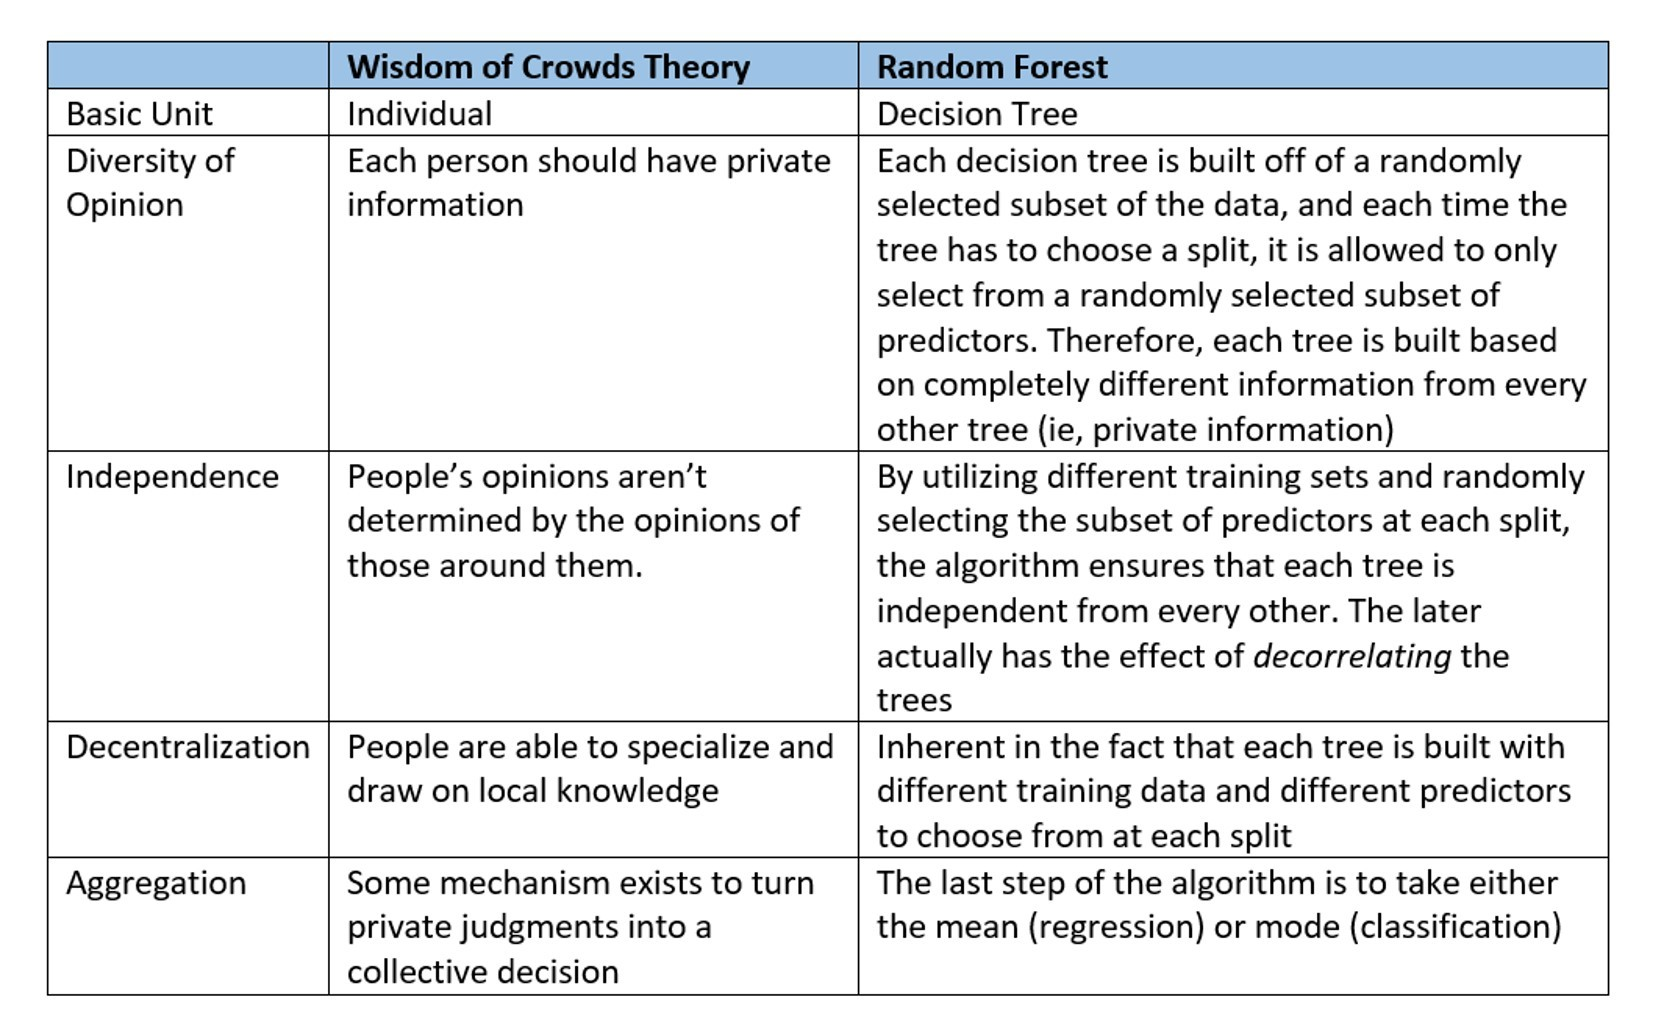

- Statistically speaking, Random Forest is simply trying to __reduce the variance in prediction by averaging a large number of independent, uncorrelated, individual predictions__
- Philosophically, Random Forest is simply applying many of the ideas behind the __Wisdom of Crowds__.

## 4.4 Concept behind random forest

The random forest is a model made up of many decision trees. Rather than just being a forest though, this model is random because of two concepts:

1. Random sampling of data points
2. Splitting nodes based on subsets of features

<a id = randomsampling></a>

###  4.4.1 __Random Sampling__<br/>

- One of the keys behind the random forest is that __each tree trains on random samples__ of the data points. 
- The samples are drawn with _replacement_ (known as __bootstrapping__) which means that some samples will be trained on in a single tree multiple times (we can also disable this behavior if we want).
- The idea is that by training each tree on different samples, although __each tree__ might have __high variance__ with respect to a particular set of the training data, overall, the __entire forest __will have __low variance__.
- This procedure of training each individual learner on different subsets of the data and then averaging the predictions is known as __bagging__, short for bootstrap aggregating.

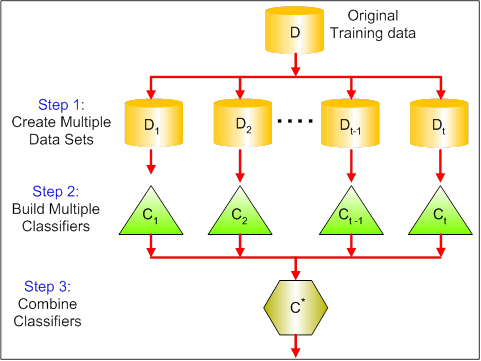

To more clearly understand bagging summarised below are the steps to follow: 

1. __Create Multiple DataSets__:
    - Sampling is done with replacement on the original data and new datasets are formed.
    - The new data sets can have a fraction of the columns as well as rows, which are generally hyper-parameters in a bagging model
    - Taking row and column fractions less than 1 helps in making robust models, less prone to overfitting
2. __Build Multiple Classifiers__:
    - Classifiers are built on each data set.
    - Generally the same classifier is modeled on each data set and predictions are made.
3. __Combine Classifiers__:
    - The predictions of all the classifiers are combined using either mean or mode value depending on the problem at hand.
    - Generally __mean__ are used for __regression__ problems and __mode__ is used for __classification__ problems.  
    - The combined values are generally more robust than a single model.
    
<a id = randomsubset></a>

### 4.4.2 __Random Subsets of Features__

- Another concept behind the random forest is that only a __subset__ of all the __features__ are considered for splitting each node in each decision tree. Generally this is set to __sqrt(n_features)__ meaning that at each node, the decision tree considers splitting on a sample of the features totaling the square root of the total number of features. 
- The random forest _can_ also be trained considering __all the features__ at every node. (These options can be controlled in the Scikit-Learn random forest implementation).


The random forest combines hundreds or __thousands of decision trees__, trains each one on a __slightly different set of the observations__ (sampling the data points with replacement) and also __splits nodes in each tree considering only a limited number of the features.__ The final predictions made by the random forest are made by __averaging the predictions of each individual tree.__

### 4.5 Advantages and Disadvantages:

__Advantages__


- It can be used for __both regression and classification__ tasks and that it’s easy to view the relative importance it assigns to the input features.

- Random forest classifier __handle the missing values__ on its own.

- Random Forest is also considered as a very handy and easy to use algorithm, because it’s __default hyperparameters often produce a good prediction result__. The number of hyperparameters is also not that high and they are straightforward to understand.

- One of the big problems in machine learning is overfitting, but most of the time this won’t happen that easy to a random forest classifier. That’s because if there are __enough trees__ in the forest, the classifier __won’t overfit__ the model.

__Shortcomings__

- The main limitation of Random Forest is that a __large number of trees__ can make the algorithm __slow and ineffective for real-time predictions.__ In general, these algorithms are fast to train, but quite slow to create predictions once they are trained. A more accurate prediction requires more trees, which results in a slower model. In most real-world applications the random forest algorithm is fast enough, but there can certainly be situations where run-time performance is important and other approaches would be preferred.

- Random Forest is a predictive modeling tool and __not a descriptive tool__. That means, if you are looking for a description of the relationships in your data, other approaches would be preferred.

- Random Forest can feel like a __black box approach for statistical modelers__ – you have __very little control__ on what the model does. You can at best – try different parameters and random seeds!

### 4.6 Use Cases:

The random forest algorithm is used in a lot of different fields like:
- __Banking__
    - In Banking it is used for example to detect customers who will use the bank’s services more frequently than others and repay their debt in time. In this domain it is also used to detect fraud customers who want to scam the bank.
- __Stock Market__,
    - In finance, it is used to determine a stock’s behaviour in the future.
- __Medicine__ 
    - In the healthcare domain it is used to identify the correct combination of components in medicine and to analyze a patient’s medical history to identify diseases.
- __E-Commerce__
    -  To determine whether a customer will actually like the product or not.

### 4.8 Preparing X and y using pandas

In [ ]:
X = titanic.loc[:,titanic.columns != 'Survived']
X.head()
y = titanic.Survived 

### 4.9 Splitting X and y into training and test datasets.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
print(X_train.shape)
print(y_train.shape)

### 4.9 Random Forest in scikit-learn

To apply any machine learning algorithm on your dataset, basically there are 4 steps:
1. Load the algorithm
2. Instantiate and Fit the model to the training dataset
3. Prediction on the test set
4. Calculating the accuracy of the model

The code block given below shows how these steps are carried out:<br/>

``` from sklearn.ensemble import RandomForestClassifier
    ```
    <br>
``` model = RandomForestClassifier() ``` 
    <br>
``` model.fit(X, y) ``` 
    <br>
``` predicted= model.predict(x_test) ``` 

- __Model without parameter specification__

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)

- __Model with parameters specified__

In [ ]:
model1 = RandomForestClassifier(random_state = 0,
                                n_estimators = 15,
                                min_samples_split = 2,
                                min_samples_leaf = 1)

model1.fit(X_train, y_train)

### 4.10 Using the Model for Prediction

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_train1 = model1.predict(X_train)

In [ ]:
y_pred_test = model.predict(X_test)                                                           # make predictions on the testing set
y_pred_test1 = model1.predict(X_test)

- Now lets see some model evaluation techniques.

## 5. Model evaluation 

__Error__ is the _deviation_ of the values _predicted_ by the model with the _true_ values.<br/>
We will use __accuracy score __ and __confusion matrix__ for evaluation.

### 5.1 Model Evaluation using __accuracy_score__

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy score for test data using the model without parameter specification:', accuracy_score(y_test,y_pred_test))
print('Accuracy score for test data using the model with parameter specification:', accuracy_score(y_test,y_pred_test1))

You can see that the accuracy has __improved__ when we have altered the default parameters.


### 5.2 Model Evaluation using confusion matrix

A __confusion matrix__ is a __summary__ of prediction results on a classification problem.

The number of correct and incorrect predictions are summarized with count values and broken down by each class. <br/>
Below is a diagram showing a general confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test))

confusion_matrix.index = ['Actual Died','Actual Survived']
confusion_matrix.columns = ['Predicted Died','Predicted Survived']
print(confusion_matrix)

This means 95 + 46 = __141 correct predictions__ & 27 + 11 = __38 false predictions__.

- __Confusion matrix__ for the prediction by the random forest classifier when the __parameters are specified__. 

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test1))

confusion_matrix.index = ['Actual Died','Actual Survived']
confusion_matrix.columns = ['Predicted Died','Predicted Survived']
print(confusion_matrix)

This means 96 + 46 = __142 correct predictions__ & 27 + 10 = __37 false predictions__.

 Observe that the number of correct prediction have __increased__ compared to our model where the default parameters are used.<br/>
 Now, we will see a way to automatically find the best parameters. 

## 6. Random forest with RandomizedsearchCV
<br/>
Applying __RandomizedsearchCV__ method for __exhaustive search over specified parameter values__ of estimator.<br/>
To know more about the different parameters in random forest classifier, refer the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html). <br/>
Below we will apply gridsearch over the following parameters:
- criterion 
- max_depth 
- n_estimators
- min_samples_split
- min_samples_leaf

You can change other parameters also and compare the impact of it via calculating __accuracy score & confusion matrix__

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# parameters for GridSearchCV
# specify parameters and distributions to sample from
param_dist = {"max_depth": range(2,5),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "n_estimators": [100, 400, 700, 1000, 1500],
              "criterion" : ["gini", "entropy"],
              'max_features': ['sqrt', 'log2', None]
             }
# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(model, param_distributions = param_dist,
                                   n_iter = n_iter_search,
                                   n_jobs = -1)

In [ ]:
random_search.fit(X_train, y_train)

- Using the model for __prediction__

In [ ]:
y_pred_test1 = random_search.predict(X_test)

- __Model Evaluation__ using __accuracy_score__

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy score on test data with RandomizedSearchCV is:', accuracy_score(y_test,y_pred_test1))

- __Model Evaluation__ using __confusion matrix__

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred_test1))

confusion_matrix.index = ['Actual Died','Actual Survived']
confusion_matrix.columns = ['Predicted Died','Predicted Survived']
print(confusion_matrix)

You can see 95 + 49 = __144 correct predictions__ & 26 + 9 = __35 false predictions__.

__Observations:__

- With __RandomizedSearchCV__ *accuracy_score* __increased__ to __0.804__ and the __number of correct predictions increased to 144__ and number of false predictions __decreased__ to __35__. 

Courtesy - INSAID & Lavi Nigam